In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")



In [3]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
train.columns

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

In [5]:
train = train[['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


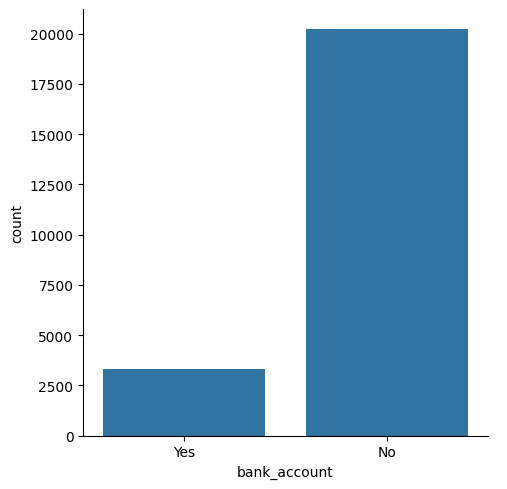

In [7]:
# Target distribuution
sns.catplot(x="bank_account", kind="count", data=train);

In [8]:
# Change household to "int" type
train = train.astype({"household_size": "int"})
print(train["household_size"].dtype)

int64


In [9]:
train["country"].value_counts()

,count
country,
Rwanda,8735
Tanzania,6620
Kenya,6068
Uganda,2101


## Visualization

##### Marital Status Exploration

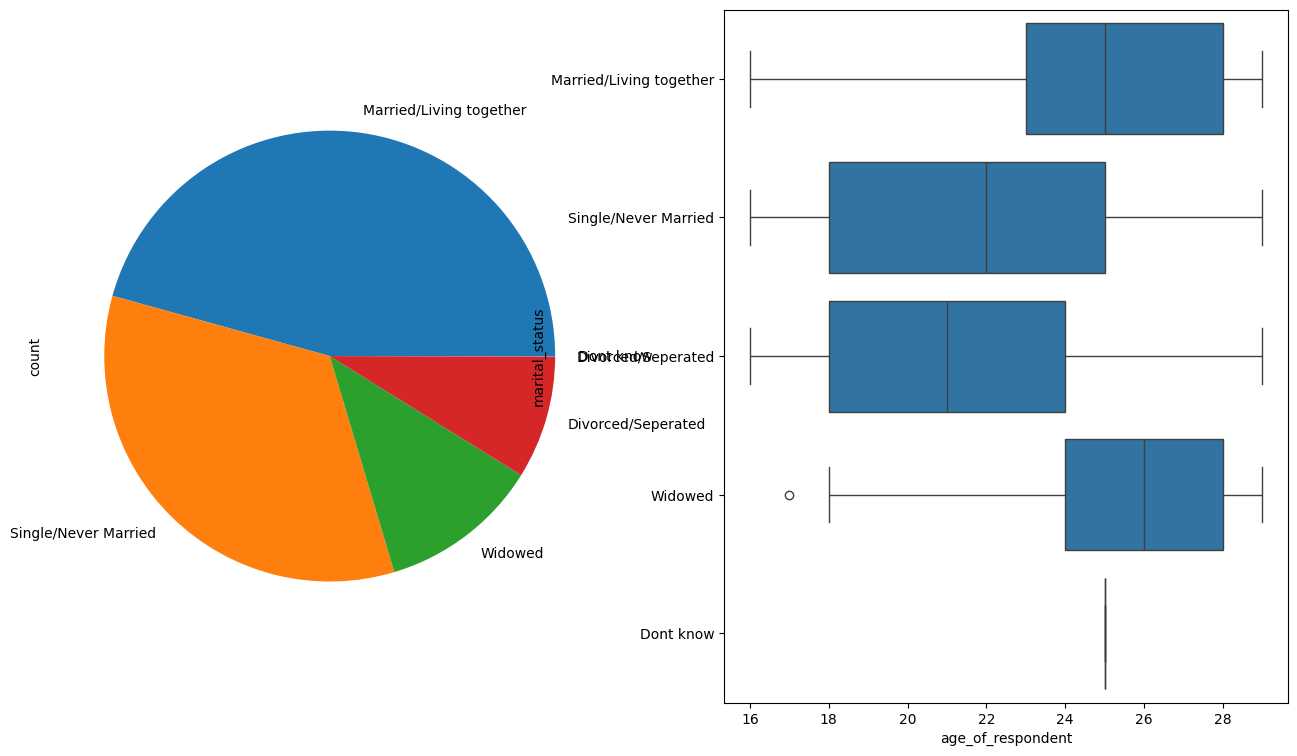

In [10]:
_,ax = plt.subplots(1,2,figsize=(16,9))
train.marital_status.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=train.query("age_of_respondent<30"), y='marital_status',
            x='age_of_respondent', ax=ax[1]);

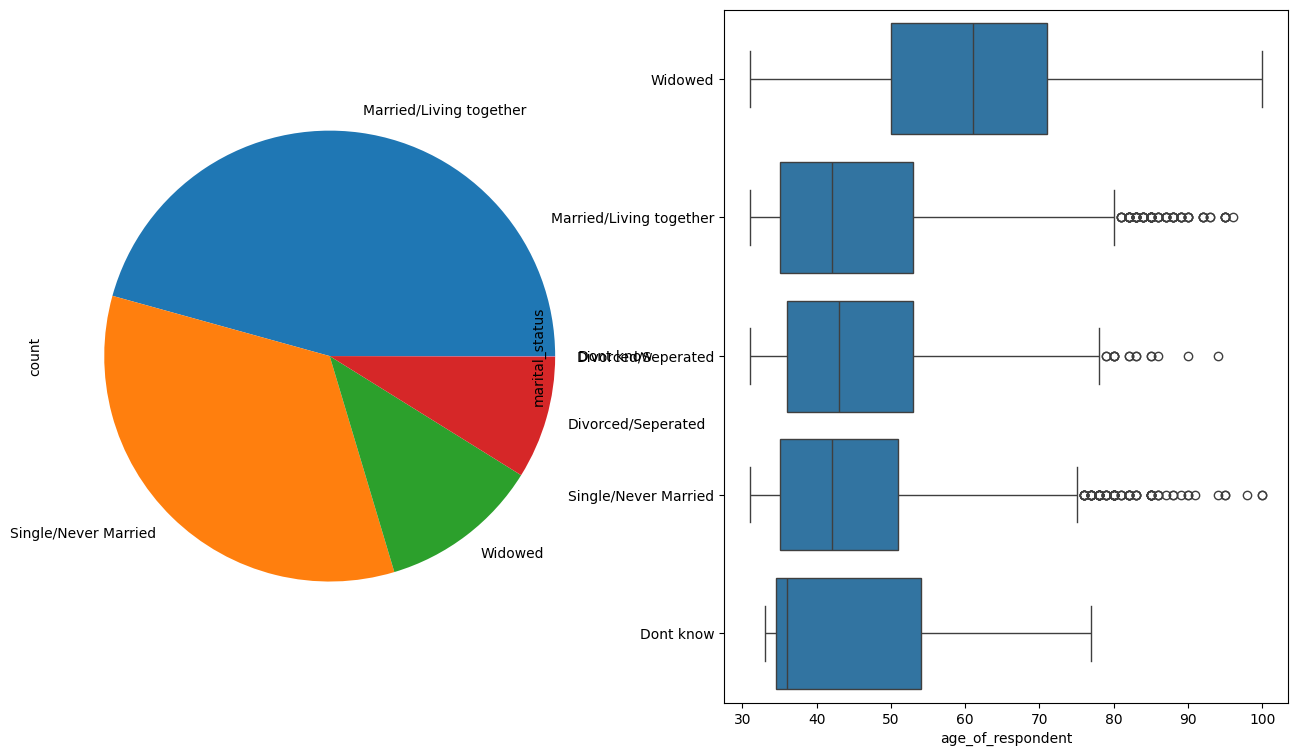

In [11]:
_,ax = plt.subplots(1,2,figsize=(16,9))
train.marital_status.value_counts().plot.pie(ax=ax[0])
sns.boxplot(data=train.query("age_of_respondent>30"), y='marital_status',
            x='age_of_respondent', ax=ax[1]);

In [12]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [13]:
test.isnull().any()

,0
country,False
year,False
uniqueid,False
location_type,False
cellphone_access,False
household_size,False
age_of_respondent,False
gender_of_respondent,False
relationship_with_head,False
marital_status,False


In [14]:
test["year"] = test["year"].astype("object")

## Modelling

In [15]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [16]:
target = "bank_account"
features = ["year", "location_type", "country", "cellphone_access", "household_size", "age_of_respondent",
           "household_size", "gender_of_respondent", "relationship_with_head", "marital_status",
           "education_level", "job_type"]

# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

X = train[features]
y = train[target]

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [17]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)

    # categorical features to be converted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]

    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)

    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])

    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)

    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)


    return data

In [18]:
# preprocess the train data
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [19]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


In [20]:
X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=42)

* The parameter `stratify = y_train` ensures an equal balance of values from both classes ("yes" and "no") for both train and validation sets.

In [21]:
print(X_Train.shape)

(21171, 37)


### Baseline Model

In [22]:
# Linear model
lg_model = LogisticRegression()

# Fit model
lg_model.fit(X_Train, y_Train)

lg_y_pred = lg_model.predict(X_Val)

print("Error rate of Linear model classifier: ", 1 - accuracy_score(y_val, lg_y_pred))

Error rate of Linear model classifier:  0.11219719507012327


In [23]:
# Random Forest Classifier
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_Train, y_Train)

rf_y_pred = rf_model.predict(X_Val)

print("Error rate of random forest classifier is ", 1 -  accuracy_score(y_val, rf_y_pred))

Error rate of random forest classifier is  0.13387165320866978


In [24]:
# K - Nearest Neighbours
kn_model = KNeighborsClassifier()

# Fit the model
kn_model.fit(X_Train, y_Train)

kn_y_pred = kn_model.predict(X_Val)

print("Error rate of random forest classifier is ", 1 -  accuracy_score(y_val, kn_y_pred))

Error rate of random forest classifier is  0.11984700382490443


In [25]:
# Decission trees
dt_model = DecisionTreeClassifier()

# Fit the model
dt_model.fit(X_Train, y_Train)

dt_y_pred = dt_model.predict(X_Val)

print("The error rate of our extra trees model is ", 1 - accuracy_score(y_val, dt_y_pred))

The error rate of our extra trees model is  0.16404589885252874


In [26]:
# create model
xg_model = XGBClassifier()

# fit the model
xg_model.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
xg_y_pred = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_pred))

Error rate of XGB classifier:  0.11177220569485757


In [28]:
accuracy = accuracy_score(y_val, xg_y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.82%


In [29]:
# Get the predicted result for the test Data
test.bank_account = xg_model.predict(processed_test)

# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

submission.sample(5)

,uniqueid,bank_account
9769,uniqueid_2686 x Uganda,0
7236,uniqueid_7511 x Tanzania,0
1121,uniqueid_7190 x Kenya,0
8340,uniqueid_8615 x Tanzania,1
5069,uniqueid_11204 x Rwanda,0


### Feature importance

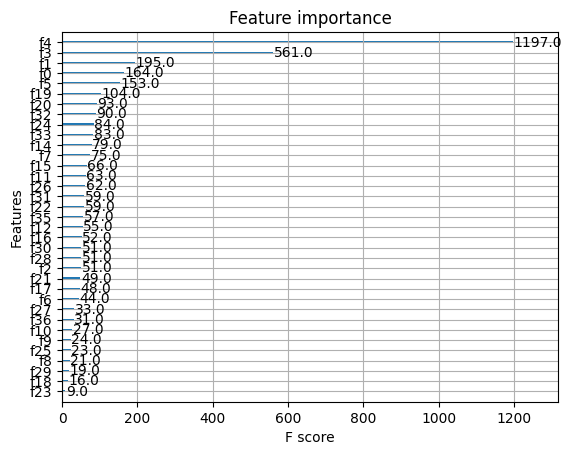

<Figure size 1800x2000 with 0 Axes>

In [30]:
xgb.plot_importance(xg_model)
plt.figure(figsize = (18, 20))
plt.show();

In [31]:
# Save model
import pickle
with open ("conchita-fin-inclusion-last.pkl", "wb") as f:
    pickle.dump(xg_model, f)



In [32]:
#load model to convert into python

with open('conchita-fin-inclusion-last.pkl', 'rb') as file:
    model = pickle.load(file)

### Deployment

In [33]:
%%writefile conchitaapplast.py
import pickle
import streamlit as st
import pandas as pd
import numpy as np

html_temp = """
<div style="background-color:tomato;padding:10px">
<h2 style="color:white;text-align:center;">Financial Inclusion in Africa</h2>
</div>"""
st.markdown(html_temp,unsafe_allow_html=True)

# Create a subheader with subheader method
st.subheader("Get your financial inclusion status")

# Create a markdown with markdown method
st.markdown(
    """
    ## About the app

    This app predicts the financial inclusion status of an individual in Africa.

    ## About the data

    The data was collected during the Finscope survey in 2016 and 2018.

    ## About the model

    The model was trained using XGBoost Classifier.
    """
)

# Create a text with text method
st.text("Please fill the form below")

# Load the pickled model
with open('conchita-fin-inclusion-last.pkl', 'rb') as f:
    model = pickle.load(f)

# We created selectbox for categorical columns and used slider
# numerical values ,specified range and step

# Create a selectbox for the location
countries = ('Kenya', 'Uganda', 'Tanzania',
'Burundi', 'Rwanda', 'South Sudan',
'Ethiopia', 'Somalia', 'Djibouti', 'Sudan', 'Eritrea',
'Central African Republic', 'Congo', 'Democratic Republic of the Congo',
'Angola', 'Mozambique', 'Malawi', 'Zambia', 'Mauritius', 'Madagascar',
'Zimbabwe', 'Namibia', 'Botswana', 'Lesotho', 'Swaziland', 'Comoros',
'Seychelles', 'Mauritania', 'Gambia', 'Guinea-Bissau', 'Guinea', 'Sierra Leone',
'Liberia', 'Cote dIvoire', 'Burkina Faso', 'Ghana', 'Togo', 'Benin', 'Niger',
'Nigeria', 'Chad', 'Cameroon', 'Equatorial Guinea', 'Gabon', 'Cabo Verde',
'Sao Tome and Principe', 'Republic of the Congo')

country = st.selectbox('country', countries)

# Create a selectbox for the location type
location_type = st.selectbox('Location Type', ('Rural', 'Urban'))

# cell phone access
cellphone_access = st.selectbox('Cell Phone Access', ('Yes', 'No'))

# Create a slider for the household size
household_size = st.slider('Household Size', 1, 20, 1)

# Create a slider for the age of the respondent
respondent_age = st.slider('Respondent Age', 16, 100, 16)

# Create a job type selectbox
job_type = st.selectbox('Job Type', ('Self employed', 'Informally employed',
'Formally employed Government', 'Remittance Dependent', 'Farming and Fishing',
'Formally employed Private', 'No Income', 'Other Income', 'Government Dependent'))

# Create a marital status selectbox
marital_status = st.selectbox('Marital Status', ('Married/Living together', 'Widowed',
'Divorced/Seperated', 'Single/Never Married', 'Dont know'))

# Gender
gender_of_respondent = st.selectbox("Gender", ("Male", "Female"))

# Relationship with head
relationship_with_head = st.selectbox("Relationship with head", ("Head of Household", "Spouse", "Child",
"Parent", "Other relative", "Other non-relatives"))


# in order to recieved client inputs appended these inputs (created above)
# into dictionary as we mentioned before. And We returned into dataframe.
data = {"country": country,
    "location_type": location_type,
        "cellphone_access": cellphone_access,
        "household_size": household_size,
        "respondent_age": respondent_age,
        "job_type": job_type,
        "marital_status": marital_status,
        "gender_of_respondent": gender_of_respondent,
        "relationship_with_head": relationship_with_head}

# Convert data into dataframe
df = pd.DataFrame.from_dict([data])

# And appended column names into column list.
# We need columns to use with reindex method as we mentioned before.
columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
]
df = pd.get_dummies(df).reindex(columns=columns, fill_value=0)
prediction = model.predict(df)

# Submit button to predict
if st.button('Predict'):
    if prediction == 0:
        st.write('You are not financially included')
    else:
        st.write('Hello, you are financially included')

# Display probabilities
if st.button('Show probabilities'):
    probabilities = model.predict_proba(df)
    st.write(probabilities)
    st.write("o = not financially included, 1 = financially included")






Writing conchitaapplast.py


In [43]:
%%writefile conchitaapp.py

#import packages
import streamlit as st
import joblib
import pandas as pd
from os.path import dirname, join, realpath

# add banner image
st.header("Financial Inclusion in Africa")
st.subheader(
    """
How likely is it for one to have a bank acccount?.
"""
)

# form to collect user information
my_form = st.form(key="financial_form")
country = my_form.selectbox("select country", ("Tanzania", "kenya", "Uganda", "Rwanda"))
location_type = my_form.selectbox("select location", ("Rural", "Urban"))
year = my_form.number_input("Inter year", min_value=2000, max_value=2100)
cellphone_access = my_form.selectbox("Do you have a cellphone?", ("Yes", "No"))
gender_of_respondent = my_form.selectbox("Gender", ("Female", "Male"))
relationship_with_head = my_form.selectbox(
    "what is your relationship with the head of the family",
    (
        "Spouse",
        "Head of Household",
        "Other relative",
        "Child",
        "Parent",
        "Other non-relatives",
    ),
)
marital_status = my_form.selectbox(
    "Your marital status",
    (
        "Married/Living together",
        "Widowed",
        "Single/Never Married",
        "Divorced/Seperated",
        "Dont know",
    ),
)
education_level = my_form.selectbox(
    "Your education level",
    (
        "Secondary education",
        "No formal education",
        "Vocation/Specialised training",
        "Primary education",
        "Tertiary education",
        "Other/Dont know/RTA",
    ),
)
job_type = my_form.selectbox(
    "Your job type",
    (
        "Self employed",
        "Government Dependent",
        "Formally employed Private",
        "Informally employed",
        "Formally employed Government",
        "Farming and Fishing",
        "Remittance Dependent",
        "Other Income",
        "Dont Know/Refuse to answer",
        "No Income",
    ),
)
household_size = my_form.number_input(
    "How many people are living in the house?", min_value=1, max_value=100
)

age_of_respondent = my_form.number_input("Your age", min_value=18, max_value=120)

submit = my_form.form_submit_button(label="make prediction")


# load the model and one-hot-encoder and scaler

with open(
    join(dirname(realpath(__file__)), "fin-inclusion.pkl"),
    "rb",
) as f:
    model = joblib.load(f)

@st.cache
# function to clean and tranform the input
#def preprocessing_data(data, enc, scaler):
def preprocessing_data(data):

    # Convert the following numerical labels from integer to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(
        float
    )


    return data


if submit:

    # collect inputs
    input = {
        "country": country,
        "year": year,
        "location_type": location_type,
        "cellphone_access": cellphone_access,
        "household_size": household_size,
        "age_of_respondent": age_of_respondent,
        "gender_of_respondent": gender_of_respondent,
        "relationship_with_head": relationship_with_head,
        "marital_status": marital_status,
        "education_level": education_level,
        "job_type": job_type,
    }

    # create a dataframe
    data = pd.DataFrame(input, index=[0])

    # clean and transform input
    transformed_data = preprocessing_data(data=data)

    # perform prediction
    prediction = model.predict(transformed_data)
    output = int(prediction[0])
    probas = model.predict_proba(transformed_data)
    probability = "{:.2f}".format(float(probas[:, output]))

    # Display results
    st.header("Results")
    if output == 1:
        st.write(
            "You are most likely to have a bank account with probability of {} 😊".format(
                probability
            )
        )
    elif output == 0:
        st.write(
            "You are most likely not to have a bank account with probability of {} 😔".format(
                probability
            )
        )



Overwriting conchitaapp.py
